# PROJECT


-1.0 import lib

-2.0 create data set

-3.0 train ML model

-4.0 train DL model

-5.0 process my image data set

-6.0 use ML model to predict

-7.0 use DL model to predeict



## 1.0 IMPORT

In [203]:
import tensorflow as tf
tf.random.set_seed(42)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
from matplotlib import pyplot as plt
import random
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import cv2
import seaborn as sb
import datetime
from sklearn.preprocessing import StandardScaler 
import imutils
import os
from imutils.perspective import four_point_transform
from imutils import contours
#import easyocr
import cv2
from sklearn.svm import SVC
from keras.datasets import mnist
import numpy as np
#from skimage.feature import hog
from matplotlib import pyplot, pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from PIL import Image
from numpy import asarray

In [2]:
print('LETS START')
#SHUAICHEN YAN 2022.04.11

LETS START


In [434]:
print('LETS START AGAIN')

LETS START AGAIN


## 2.0A IMPORT DATASET HOG

In [77]:
#AUGMENTATION TO AUTO GENERATE SAMPLE
def MagicSample(img):
    kernel = np.ones((4,4),np.uint8)
    hei, wid = img.shape
    pc = (wid // 2, hei // 2)
    Rotation = cv2.getRotationMatrix2D(pc, 5, 1.0)
    Right = np.float32([[1, 0, 2], [0, 1, 0]])
    Left = np.float32([[1, 0, -2], [0, 1, 0]])
    #PREPARE MODIFICATION ON ORIGINAL COPY
    blurred = cv2.GaussianBlur(img,(3,3),0)
    closed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    eroded = cv2.erode(img, kernel)
    dilated = cv2.dilate(img,kernel)
    righted = cv2.warpAffine(img, Right, (wid, hei), borderValue=(255,255,255))
    lefted = cv2.warpAffine(img, Left, (wid, hei), borderValue=(255,255,255))
    rotated = cv2.warpAffine(img, Rotation, (wid, hei), borderValue=(255,255,255))

    return[img,blurred,closed,eroded,dilated,righted,lefted,rotated]

In [78]:
#PREPROCESS DATA SET WITH ORIENTATION AND HOG
#source_dir=os.path.dirname(__file__)
source_dir=r'/Users/mac/Desktop/PROJ/0409/PROJ/DATA_SET/'
os.chdir(source_dir)
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
#walk thru directory for multiple target files
#CRAETE EMPTY X,Y FOLDER
DataSet_HOG=[]
DataLabel_HOG=[]
#WALK THRU
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    for dirname in dirnames: 
        cur_dir=source_dir+dirname+'/'
        os.chdir(cur_dir)
        #print(dirname)
        #GO THRU DATA SET TO PROCESS EACH IMAGE
        for file in os.listdir(cur_dir):
            filename=os.fsdecode(file)
            if '.jpg' in filename:
                img = cv2.imread(filename,0)
                for img in MagicSample(img):
                    #FIND CORRECT ORIENTATION
                    m = cv2.moments(img)
                    if not abs(m['mu02']) < 1e-2:
                        skew = m['mu11']/m['mu02']
                        M = np.float32([[1, skew, -0.5*20*skew], [0, 1, 0]])
                        img = cv2.warpAffine(img,M,(20, 20),flags=affine_flags)
                    else:
                        img = img.copy()
                    #cv2.imwrite(dirname+'_'+'imm.png',img)
                    #break
                    #PREPARE HISTOGRAM OF GRADIENT
                    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
                    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
                    mag, ang = cv2.cartToPolar(gx, gy)
                    bins = np.int32(16*ang/(2*np.pi))   
                    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
                    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
                    hists = [np.bincount(b.ravel(), m.ravel(), 16) for b, m in zip(bin_cells, mag_cells)]
                    hist = np.hstack(hists) 
                    #STORE IMG HOG INTO TRAINING SET
                    DataSet_HOG.append(hist)
                    DataLabel_HOG.append(dirname)
print(len(DataLabel_HOG))
print(len(DataSet_HOG))
print(DataSet_HOG[0].shape)

2840
2840
(64,)


In [123]:
#RESHAPE DATA SET
DataSet_HOG_RESHAPE = np.float32(DataSet_HOG).reshape(-1,64)
DataLabel_HOG_RESHAPE = np.array(DataLabel_HOG)
#CREATE LABEL LIST
Label_Set=set(DataLabel_HOG)
DataSet_HOG_RESHAPE.shape, DataLabel_HOG_RESHAPE.shape
Label_Set

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'X',
 'Y',
 'Z'}

In [325]:
#SPLIT BETWEEN TRAINING SET AND TESTING SET
x_train, x_test, y_train, y_test = train_test_split(DataSet_HOG_RESHAPE, DataLabel_HOG_RESHAPE, test_size=0.5, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1420, 64), (1420, 64), (1420,), (1420,))

# 2.0B IMPORT DATASET FEATURE

In [502]:
#PREPROCESS DATA SET WITH FEATURE EXTRACTION OF CONTOURS
source_dir=r'/Users/mac/Desktop/PROJ/0409/PROJ/DATA_SET/'
os.chdir(source_dir)
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
#walk thru directory for multiple target files
#CREATE EMPTY X Y 
DataSet_FEATURE=[]
DataLabel_FEATURE=[]
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    for dirname in dirnames: 
        cur_dir=source_dir+dirname+'/'
        os.chdir(cur_dir)
        #print(dirname)
        for file in os.listdir(cur_dir):
            filename=os.fsdecode(file)
            if '.jpg' in filename:
                #print(filename)
                img = cv2.imread(filename,0)
                for img in MagicSample(img):
                    #FIND CORRECT ORIENTATION
                    m = cv2.moments(img)
                    if not abs(m['mu02']) < 1e-2:
                        skew = m['mu11']/m['mu02']
                        M = np.float32([[1, skew, -0.5*20*skew], [0, 1, 0]])
                        img = cv2.warpAffine(img,M,(20, 20),flags=affine_flags)
                    else:
                        img = img.copy()
                    #cv2.imwrite(dirname+'_'+'imm.png',img)
                    #break
                    #GRAB FEATURES OF EACH IMGE AND SAVE
                    flat=img.flatten()
                    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    cnt = contours[0]
                    if cnt is None:
                        print("error, no cont detected")
                        exit()
                    # Calculate Moments
                    new_M = cv2.moments(cnt)
                    # cx = int(M['m10']/M['m00'])
                    cy = int(new_M['m01']/(new_M['m00'] + 1e-5)) # add small value to remove division by 
                    _ , _ , width , height = cv2.boundingRect(cnt)
                    each_img=[]
                    for i in flat:
                        each_img.append(i)
                    each_img.append(cv2.countNonZero(img))
                    each_img.append(float(width/height))
                    each_img.append(cv2.contourArea(cnt))
                    each_img.append(cv2.arcLength(cnt,True))
                    each_img.append(cy)
                    each_img.append(width)
                    #APPEND INFO IN TO XY SET
                    DataSet_FEATURE.append(each_img)
                    DataLabel_FEATURE.append(dirname)
print(len(DataSet_FEATURE))
print(DataLabel_FEATURE[1])
print(len(DataSet_FEATURE[1]))

2840
R
406


In [576]:
#SPLIT BETWEEN TRAINING SET AND TESTING SET
x_train1, x_test1, y_train1, y_test1 = train_test_split(DataSet_FEATURE, DataLabel_FEATURE, test_size=0.5, random_state=42)
#len(x_train1)
#x_train1[0][-6:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1420, 8, 8), (1420, 64), (1420,), (1420,))

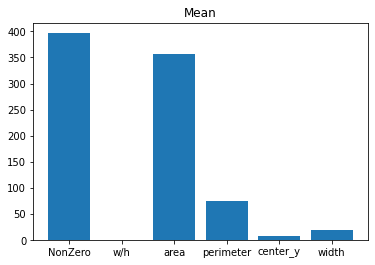

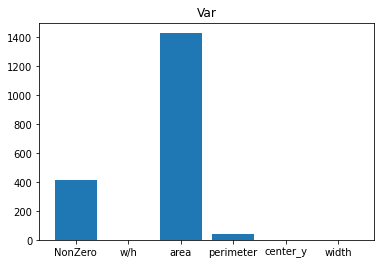

In [504]:
#GET MEAN AND VAR FOR FEATURES
for_see=[]
for i in x_train1:
    for_see.append(i[-6:])
m = np.mean(for_see, axis=0)
v = np.var(for_see, axis=0)
feature_list=['NonZero','w/h','area','perimeter','center_y','width']
plt.bar(feature_list,m)
plt.title("Mean")
plt.show()
plt.bar(feature_list,v)
plt.title("Var")
plt.show()

In [505]:
#CONVERT FEATURES INTO NUMPY ARRAY
features = np.array(x_train1)
features_test = np.array(x_test1)

## 3.0A ML MODEL HOG

In [115]:
#TRAIN SVM MODEL
model_linear = SVC(kernel='linear')
model_linear.fit(x_train, y_train)

SVC(kernel='linear')

In [124]:
#PREDICT RESULT
y_pred = model_linear.predict(x_test)
acc = sum(y_pred==y_test)/len(x_test)
print(acc)
print(classification_report(y_test, y_pred, target_names=Label_Set))

0.9394366197183098
              precision    recall  f1-score   support

           N       0.92      0.66      0.77        50
           C       0.85      0.95      0.90        43
           J       0.91      0.95      0.93        43
           X       0.97      1.00      0.99        37
           H       0.95      0.97      0.96        40
           E       0.97      0.97      0.97        38
           8       0.88      0.90      0.89        39
           3       1.00      0.96      0.98        47
           2       0.90      0.95      0.93        40
           6       0.96      0.98      0.97        48
           5       0.95      0.96      0.95        77
           Q       0.90      0.86      0.88        44
           R       0.89      0.95      0.92        42
           7       0.74      0.89      0.81        28
           F       0.96      0.88      0.91        49
           P       0.89      1.00      0.94        42
           L       0.80      0.91      0.85        45
        

In [476]:
conf_mtrx = confusion_matrix(y_test, y_pred)
print(conf_mtrx)

[[33  0  0 ...  0  0  0]
 [ 0 41  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  2 ... 43  0  0]
 [ 0  1  0 ...  0 36  0]
 [ 0  0  0 ...  0  0 33]]


<AxesSubplot:>

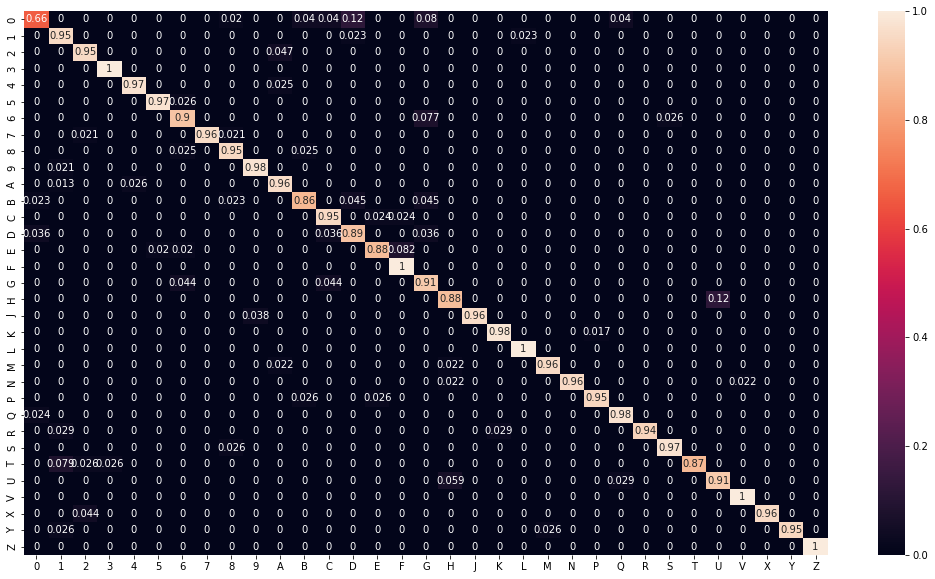

In [477]:
#GET CONFUSION MATRIX
normalized_confusion_matrix = confusion_matrix(y_test, y_pred, normalize='true')
#round_normalized_confusion_matrix = np.round(normalized_confusion_matrix)
#print((normalized_confusion_matrix))

pd_normalized_confusion_matrix = pd.DataFrame(normalized_confusion_matrix, index = [i for i in "0123456789ABCDEFGHJKLMNPQRSTUVXYZ"],
                                             columns=[i for i in "0123456789ABCDEFGHJKLMNPQRSTUVXYZ"])
plt.figure(figsize=(18,10))
sb.heatmap(pd_normalized_confusion_matrix, annot=True)

## 3.0B ML MODEL FEATURE EXTRACTION

In [506]:
#TRAIN SVM MODEL WITH 6 FEATURES
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param={'C':[2.67],'gamma':[5.383]}
model_linear2 = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param)
#model_linear2.fit(reducedFeatures, y_train1)
model_linear2.fit(features, y_train1)

GridSearchCV(estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid={'C': [2.67], 'gamma': [5.383]})

In [577]:
#PREDICT WITH 6 FEATURE MODEL
y_pred2 = model_linear2.predict(features_test)
acc2 = sum(y_pred2==y_test1)/len(features_test)
print(acc2)
print(classification_report(y_test1, y_pred2, target_names=Label_Set))

0.9556338028169014
              precision    recall  f1-score   support

           N       0.97      0.78      0.87        50
           C       0.91      0.98      0.94        43
           J       0.91      0.98      0.94        43
           X       0.95      1.00      0.97        37
           H       1.00      0.97      0.99        40
           E       1.00      1.00      1.00        38
           8       0.92      0.92      0.92        39
           3       0.98      0.94      0.96        47
           2       0.90      0.95      0.93        40
           6       1.00      1.00      1.00        48
           5       0.99      1.00      0.99        77
           Q       0.88      0.95      0.91        44
           R       0.89      0.98      0.93        42
           7       0.96      0.89      0.93        28
           F       0.95      0.86      0.90        49
           P       0.85      0.98      0.91        42
           L       0.93      0.91      0.92        45
        

<AxesSubplot:>

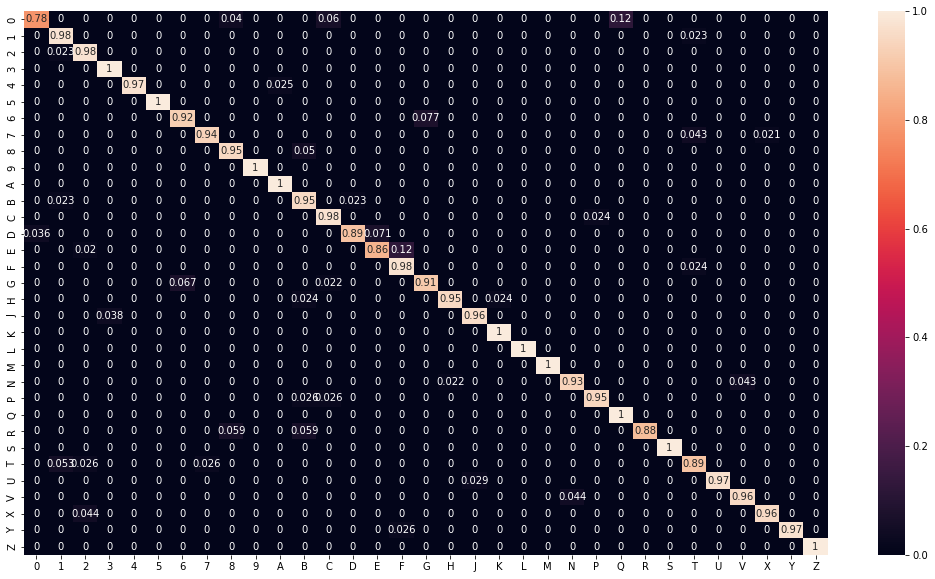

In [508]:
#GRAB CONFUSION MATRIX
normalized_confusion_matrix = confusion_matrix(y_test1, y_pred2, normalize='true')

pd_normalized_confusion_matrix = pd.DataFrame(normalized_confusion_matrix, index = [i for i in "0123456789ABCDEFGHJKLMNPQRSTUVXYZ"],
                                             columns=[i for i in "0123456789ABCDEFGHJKLMNPQRSTUVXYZ"])
plt.figure(figsize=(18,10))
sb.heatmap(pd_normalized_confusion_matrix, annot=True)

## 4.0 TRAIN DL MODLE

In [533]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers
#FIND TRAINING AND TESTING DATA SET
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(20,20),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(
        'val',  # this is the target directory
        target_size=(20,20),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [534]:
#DL MODEL DESIGN
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(20, 20, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [535]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 20, 20, 32)        55328     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 flatten_28 (Flatten)        (None, 3200)              0         
                                                                 
 dense_72 (Dense)            (None, 128)               409728    
                                                                 
 dense_73 (Dense)            (None, 36)                4644      
                                                     

In [536]:
batch_size = 1
#callbacks = [tensorboard_callback, stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 15)

Epoch 1/15


/var/folders/fm/686tc8g17mx00yvggmczykv40000gn/T/ipykernel_1375/2033400160.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


864/864 [==============================] - 14s 15ms/step - loss: 3.5431 - accuracy: 0.0498 - val_loss: 3.4557 - val_accuracy: 0.1343
Epoch 2/15
864/864 [==============================] - 12s 14ms/step - loss: 3.3899 - accuracy: 0.1204
Epoch 3/15
864/864 [==============================] - 16s 18ms/step - loss: 3.1275 - accuracy: 0.2315
Epoch 4/15
864/864 [==============================] - 16s 18ms/step - loss: 2.8131 - accuracy: 0.3009
Epoch 5/15
864/864 [==============================] - 16s 18ms/step - loss: 2.5195 - accuracy: 0.3889
Epoch 6/15
864/864 [==============================] - 22s 26ms/step - loss: 2.1914 - accuracy: 0.4630
Epoch 7/15
864/864 [==============================] - 26s 30ms/step - loss: 1.9517 - accuracy: 0.5093
Epoch 8/15
864/864 [==============================] - 20s 23ms/step - loss: 1.7924 - accuracy: 0.5289
Epoch 9/15
864/864 [==============================] - 20s 23ms/step - loss: 1.5941 - accuracy: 0.5799
Epoch 10/15
864/864 [==============================

In [424]:
model.save('0409model30')

INFO:tensorflow:Assets written to: 0409model30/assets


## 5.0 PREPROCESS MY IMAGE

IMG_3013.JPG
[[[478 311]]

 [[355 309]]

 [[352 370]]

 [[475 372]]]
we have40
we have 7 useful contours
[[3, 16, 18, 35], [18, 16, 18, 35], [32, 15, 18, 36], [48, 15, 17, 36], [77, 15, 17, 35], [91, 15, 17, 35], [106, 15, 17, 35]]


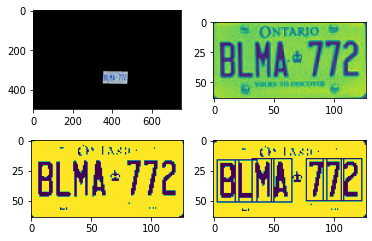

In [584]:
#PREPROCESS VALIDATE IMAGE
source_dir=r'/Users/mac/Desktop/PROJ/0409/PROJ/'
os.chdir(source_dir)
Validate_Plate_Container=[]
#walk thru directory for multiple target files
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    for filename in filenames: 
        #SAMPLE ONTARIO LICENSE PLATE
        if '13.JPG' in filename:
            print(filename)
            img = cv2.imread(filename)
            #print(len(img.shape))
            # pre-process the image by resizing it, converting it to
            # graycale, blurring it, and computing an edge map
            img = imutils.resize(img, height=500)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            edged = cv2.Canny(blurred, 50, 200, 255)
            critical_pts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contours = imutils.grab_contours(critical_pts)
            #sort by area from big to small
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
            #find match with 4 sides
            location = None
            for contour in contours:
                approx = cv2.approxPolyDP(contour, 20, True)
                #10--->the higher the rougher
                if len(approx) == 4:
                    location = approx
                    break
            print(location)
            mask = np.zeros(gray.shape, np.uint8)
            new_image = cv2.drawContours(mask, [location], 0,255, -1)
            new_image = cv2.bitwise_and(img, img, mask=mask)
            #CROPPING
            (x,y) = np.where(mask==255)
            (x1, y1) = (np.min(x), np.min(y))
            (x2, y2) = (np.max(x), np.max(y))
            cropped_image = img[x1:x2+1, y1:y2+1]
            #BINARY
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            (thresh,threshBLACK) = cv2.threshold(cropped_image,130,255,cv2.THRESH_BINARY)
            open_mask=cv2.morphologyEx(threshBLACK,cv2.MORPH_OPEN,(70,70))
            cv2.imwrite('rr.png',threshBLACK)
            #########################################CUT#####################
            contours = cv2.findContours(open_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            contours = contours[0] if len(contours) == 2 else contours[1]
            print('we have'+str(len(contours)))
            result=[]
            for cntr in contours:
                x,y,w,h = cv2.boundingRect(cntr)
                #print(w,h)
                #cv2.rectangle(open_mask,(x,y),(x+w,y+h),(0,255,0),1)
                if w>10 and h>10 and h<40:
                    result.append([x-2,y-2,w+4,h+4])
                    #result.append([x,y,w,h])
            result=sorted(result,key=lambda x:x[0])
            count=0
            print('we have '+str(len(result))+' useful contours')
            print(result)
            #DRAW CONTOUR OF EACH CHARACTERS
            for_display=open_mask.copy()
            for i in result:
                ROI = open_mask[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
                cv2.rectangle(for_display,(i[0],i[1]),(i[0]+i[2],i[1]+i[3]),(0,0,255),1)
                cv2.imwrite('my_X_train'+str(count)+'.png',ROI)
                count+=1   
            ##############################SUBPLOT########################################
            fig,axs = plt.subplots(2,2)
            axs[0,0].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
            axs[0,1].imshow(cropped_image)
            axs[1,0].imshow(threshBLACK)
            axs[1,1].imshow(for_display)

In [583]:
######################################RESIZE TO 20*20 ############################
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    for filename in filenames:           
        if ("my_X" in filename):
            img = cv2.imread(filename,0)
            resized = cv2.resize(img,(20,20))
            #plt.imshow(resized)
            cv2.imwrite('ReResized'+filename[6:-4]+'.png',resized)
print(1)

1


In [557]:
######################################CONVERT TO ML DATASET ############################
My_train=[]
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    name_list=[]
    for filename in filenames:  
        if ("ReResized" in filename):
            name_list.append(filename)

    name_list=sorted(name_list,key=lambda x:x[-5])
    print(name_list)
    break

['ReResizedrain0.png', 'ReResizedrain1.png', 'ReResizedrain2.png', 'ReResizedrain3.png', 'ReResizedrain4.png', 'ReResizedrain5.png', 'ReResizedrain6.png']


## 6.0A USE ML MODEL TO PREDICT HOG

In [558]:
#FEED MY IMAGE INTO ML MODEL
source_dir=r'/Users/mac/Desktop/PROJ/0409/PROJ/'
os.chdir(source_dir)
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
#walk thru directory for multiple target files
My_HOG=[]
for filename in name_list:
    img = cv2.imread(filename,0)
    #FIND CORRECT ORIENTATION
    m = cv2.moments(img)
    if not abs(m['mu02']) < 1e-2:
        skew = m['mu11']/m['mu02']
        M = np.float32([[1, skew, -0.5*20*skew], [0, 1, 0]])
        img = cv2.warpAffine(img,M,(20, 20),flags=affine_flags)
    else:
        img = img.copy()
    #PREPARE HISTOGRAM OF GRADIENT
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(16*ang/(2*np.pi))   
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), 16) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists) 
    #STORE IMG HOG INTO TRAINING SET
    My_HOG.append(hist)

print(len(My_HOG))
print(My_HOG[0].shape)

7
(64,)


In [559]:
#PREDICT MY RESULT
y_pred_my = model_linear.predict(My_HOG)
print(y_pred_my)

['8' 'L' 'M' 'A' '7' '7' '6']


In [ ]:
#FEED MY IMAGE INTO DL MODEL

In [ ]:
#PREDICT MY RESULT

8LMA776
:)


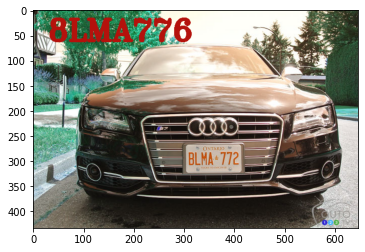

In [573]:
#VISUALIZE FOR COMPARISON
my_string=''.join(y_pred_my)
print(my_string)
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    for filename in filenames:           
        if ("13.JPG" in filename):
            img=cv2.imread(filename)
            cv2.putText(img,my_string,(30,60),cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(180,18, 12),thickness=5)
            plt.imshow(img)
#REMOVE INTERMEDIATE FILE
print(':)')

## 6.0B USE ML MODEL TO PREDICT WITH FEARTURE EXTRACTION 

In [585]:
#PREPROCESS DATA SET WITH FEATURE EXTRACTION OF CONTOURS
source_dir=r'/Users/mac/Desktop/PROJ/0409/PROJ/'
os.chdir(source_dir)
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
#walk thru directory for multiple target files
My_FEATURE=[]
print(name_list)
for filename in name_list:
        #print(filename)
        img = cv2.imread(filename,0)
        m = cv2.moments(img)
        if not abs(m['mu02']) < 1e-2:
            skew = m['mu11']/m['mu02']
            M = np.float32([[1, skew, -0.5*20*skew], [0, 1, 0]])
            img = cv2.warpAffine(img,M,(20, 20),flags=affine_flags)
        else:
            img = img.copy()
        #cv2.imwrite(dirname+'_'+'imm.png',img)
        #break
        #GRAB 6 FEATURES OF THE SAMPLE ONTARIO LICENSE PLATE IMAGE
        flat=img.flatten()
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        if cnt is None:
            print("error, no cont detected")
            exit()
        # Calculate Moments
        new_M = cv2.moments(cnt)
        # cx = int(M['m10']/M['m00'])
        cy = int(new_M['m01']/(new_M['m00'] + 1e-5)) # add small value to remove division by 
        _ , _ , width , height = cv2.boundingRect(cnt)
        each_img=[]
        for i in flat:
            each_img.append(i)
        each_img.append(cv2.countNonZero(img))
        each_img.append(float(width/height))
        each_img.append(cv2.contourArea(cnt))
        each_img.append(cv2.arcLength(cnt,True))
        each_img.append(cy)
        each_img.append(width)
        My_FEATURE.append(each_img)

print(len(My_FEATURE))
print(len(My_FEATURE[1]))

['ReResizedrain0.png', 'ReResizedrain1.png', 'ReResizedrain2.png', 'ReResizedrain3.png', 'ReResizedrain4.png', 'ReResizedrain5.png', 'ReResizedrain6.png']
7
406


['4' 'L' 'M' 'A' '2' '2' '4']
4LMA224


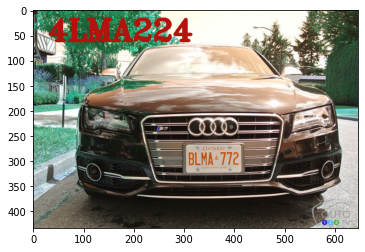

In [586]:
#PREDICT MY RESULT
y_pred_my_feature = model_linear2.predict(My_FEATURE)
print(y_pred_my_feature)
my_string2=''.join(y_pred_my_feature)
print(my_string2)
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    for filename in filenames:           
        if ("13.JPG" in filename):
            img=cv2.imread(filename)
            cv2.putText(img,my_string2,(30,60),cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(180,18, 12),thickness=5)
            plt.imshow(img)

## 7.0 use DL to predict my image

['ReResizedrain0.png', 'ReResizedrain1.png', 'ReResizedrain2.png', 'ReResizedrain3.png', 'ReResizedrain4.png', 'ReResizedrain5.png', 'ReResizedrain6.png']
(20, 20, 3)
ReResizedrain0.png
(20, 20, 3)
ReResizedrain1.png
(20, 20, 3)
ReResizedrain2.png
(20, 20, 3)
ReResizedrain3.png
(20, 20, 3)
ReResizedrain4.png
(20, 20, 3)
ReResizedrain5.png
(20, 20, 3)
ReResizedrain6.png
['G', '3', 'Q', 'U', 'H', 'H', 'N']
G3QUHHN


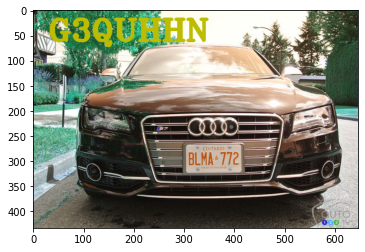

In [580]:
output=[]
print(name_list)
#CREATE DICTIONARY TO MAP CAHRACTER WITH INDEX
dic = {}
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i,c in enumerate(characters):
    dic[i] = c
#LOOP THRU SINGLE CHARACTER
for ch in name_list:
    img = cv2.imread(ch)
    print(img.shape)
    print(ch)
    imgg = img.reshape(1,20,20,3) 
    #USE DL MODEL TO PREDICT
    y_ = np.argmax(model.predict(imgg),axis=-1)[0]
    output.append(dic[y_]) #storing the result in a list

print(output)
#JOIN THE CHARACTER TOGETHER
my_string=''.join(output)
print(my_string)
#DRAW THE PLATE DETECTION RESULT ONTO IMAGE
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    for filename in filenames:           
        if ("13.JPG" in filename):
            img=cv2.imread(filename)
            cv2.putText(img,my_string,(30,60),cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(188,188, 0),thickness=5)
            plt.imshow(img)